In [ ]:
# link dataset : https://www.kaggle.com/datasets/sachinkumar413/covid-pneumonia-normal-chest-xray-images

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img

# Paths and parameters
dataset_path = '/Users/Enrico/Image/Image new/LAB/UAS/archive'
img_height, img_width = 224, 224
batch_size = 32

['COVID', 'NORMAL', 'PNEUMONIA']


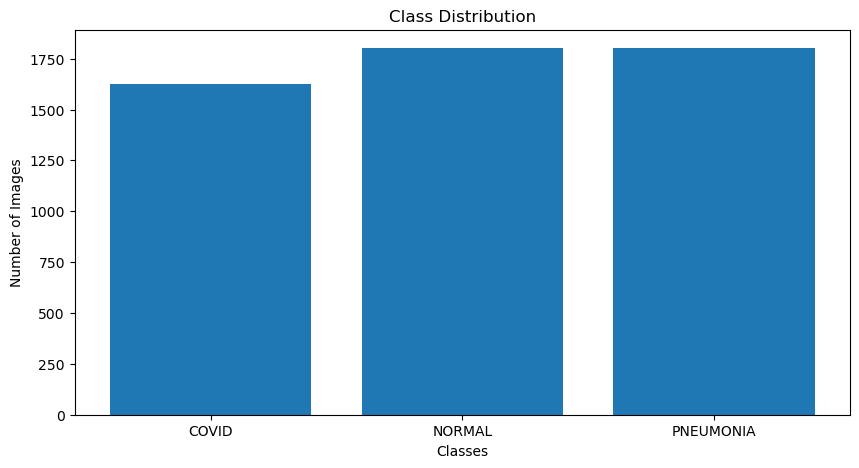

In [2]:
from collections import Counter
classes = os.listdir(dataset_path)
print(classes)
# Count images per class
class_counts = Counter()
for cls in classes:
    class_dir = os.path.join(dataset_path, cls)
    class_counts[cls] = len(os.listdir(class_dir))

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.show()

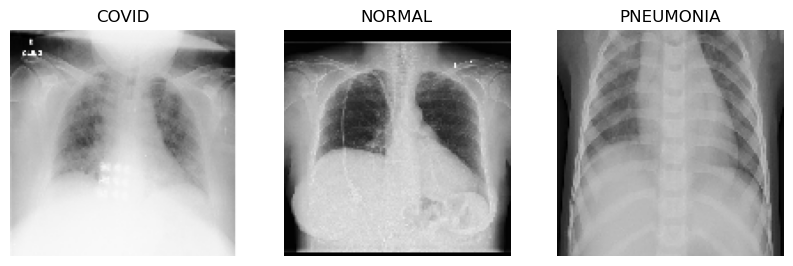

In [3]:
class_dirs = os.listdir(dataset_path)
plt.figure(figsize=(10, 10))
for i, cls in enumerate(class_dirs, start=1):
    img_path = os.path.join(dataset_path, cls, os.listdir(os.path.join(dataset_path, cls))[0])
    img = load_img(img_path, target_size=(128, 128))
    plt.subplot(3, 3, i)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.show()

In [4]:
# Data preprocessing with ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2 # 20% data untuk validation
)

# Data generators for training
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=123
)

# Data generators for validation
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=123
)

# Pisahkan validation dan test secara manual
val_samples = int(val_generator.samples * 0.5)
test_samples = val_generator.samples - val_samples

# Data generators for test
test_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=123,
    shuffle=False
)


# Display dataset splits
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_samples}")
print(f"Test samples: {test_samples}")

Found 4183 images belonging to 3 classes.
Found 1045 images belonging to 3 classes.
Found 1045 images belonging to 3 classes.
Training samples: 4183
Validation samples: 522
Test samples: 523


Displaying augmented images from training set:


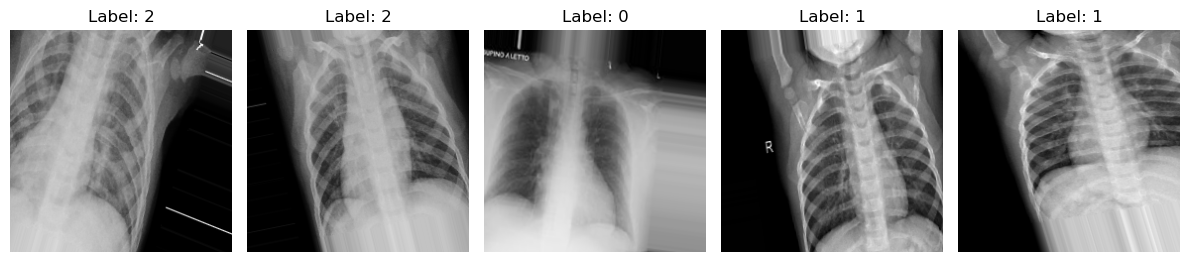

In [5]:
import matplotlib.pyplot as plt

# Fungsi untuk menampilkan beberapa gambar dari generator
def display_augmented_images(generator, num_images=5):
    images, labels = next(generator)  # Ambil satu batch dari generator
    plt.figure(figsize=(12, 6))
    
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title("Label: " + str(labels[i].argmax()))
    plt.tight_layout()
    plt.show()

# Tampilkan gambar dari train_generator
print("Displaying augmented images from training set:")
display_augmented_images(train_generator)


In [6]:
# CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

C:\Users\Enrico\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50


C:\Users\Enrico\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 115s 843ms/step - accuracy: 0.5154 - loss: 0.9604 - val_accuracy: 0.7445 - val_loss: 0.6075
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 104s 775ms/step - accuracy: 0.7187 - loss: 0.6528 - val_accuracy: 0.8163 - val_loss: 0.4881
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 109s 811ms/step - accuracy: 0.7879 - loss: 0.5571 - val_accuracy: 0.8450 - val_loss: 0.4149
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 108s 808ms/step - accuracy: 0.7989 - loss: 0.5212 - val_accuracy: 0.8383 - val_loss: 0.4266
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 105s 783ms/step - accuracy: 0.8241 - loss: 0.4862 - val_accuracy: 0.8708 - val_loss: 0.3746
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 105s 782ms/step - accuracy: 0.8022 - loss: 0.5185 - val_accuracy: 0.8900 - val_loss: 0.3420
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 106s 786ms/step - accuracy: 0.8213 - loss: 0.5004 - val_accuracy: 0.8900 - val_loss: 0.3438
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 108s 805ms/step - accuracy: 0.8260 - loss: 0.47

In [9]:
# Model evaluation
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes



33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 406ms/step - accuracy: 0.9336 - loss: 0.2286
Test Loss: 0.29633399844169617
Test Accuracy: 0.9043062329292297
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 406ms/step


In [10]:
# Classification Report
class_labels = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


Classification Report:
              precision    recall  f1-score   support

       COVID       0.92      0.97      0.94       325
      NORMAL       0.88      0.93      0.90       360
   PNEUMONIA       0.95      0.84      0.89       360

    accuracy                           0.91      1045
   macro avg       0.91      0.91      0.91      1045
weighted avg       0.91      0.91      0.91      1045



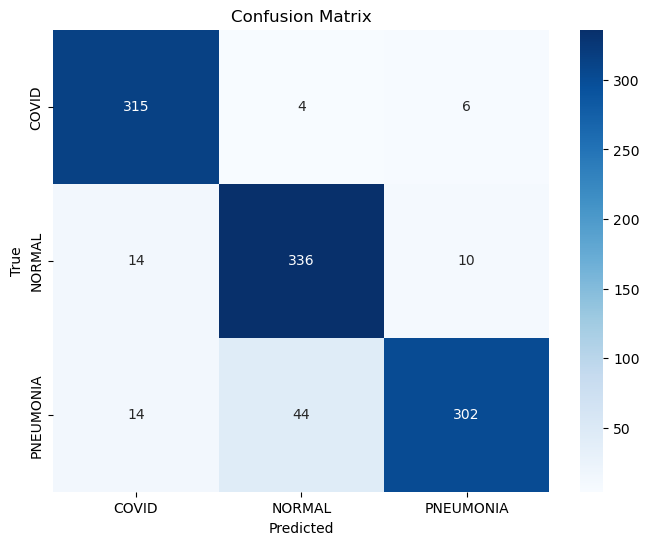

In [11]:
# Confusion Matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

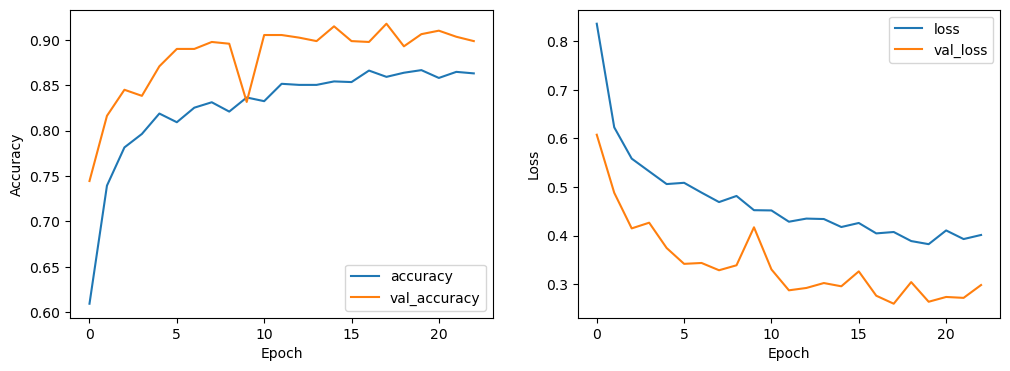

In [12]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()